In [0]:
from google.colab import files
#upload manuale dell' immagine di training e della relativa maschera
uploaded = files.upload()


Saving training_sa_crop_pat0-label.nii to training_sa_crop_pat0-label.nii


In [0]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_prediction
import matplotlib.pyplot as plt_maschera
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras import layers
from keras.layers import Activation
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image
from keras.preprocessing.image import load_img
import numpy as np
import nibabel as nib
from google.colab import files
from PIL import Image
import PIL.ImageOps  

In [0]:

img_rows = 128
img_cols = 160

img1 = nib.load('../content/training_sa_crop_pat0.nii')
img2 = nib.load('../content/training_sa_crop_pat0-label.nii')

array_training = np.array(img1.dataobj)
array_gt = np.array(img2.dataobj)

#scambio di axes (x,z,y)  a (Z,X,Y), con z slices
array_training=np.swapaxes(array_training,0,1)
array_gt=np.swapaxes(array_gt,0,1)

#scala tutte le immagini alla dimesione 128x160
from scipy.ndimage import zoom
array_training = zoom(array_training, (1, 1.007, 1.06))
array_gt= zoom(array_gt, (1, 1.007, 1.06))

#reshape dell'array in modo da aggiungere la quarta dimensione relativa al numero di canali usati (1 = scala di grigi)
array_training = array_training.reshape((array_training.shape[0], array_training.shape[1], array_training.shape[2],1))

#preprocessing delle immagini
array_training = array_training.astype('float32')
mean = np.mean(array_training)
std = np.std(array_training)

array_training -= mean
array_training /= std

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [0]:
def dice_coef(y_true, y_pred):
    #loss dice_coeff per 3 classi (valori possibili della label 0,1 e 2)
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    for l in range(0,Ncl): w[l] = np.sum( np.asarray(y_true[:,:,l]==1,np.int8) )
    w = 1/(w**2+0.00001)

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2))
    numerator = K.sum(numerator)
    
    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2))
    denominator = K.sum(denominator)
    
    gen_dice_coef = numerator/denominator
    
    return 1-2*gen_dice_coef
   
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def up_conv_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    up_conv_name_base = 'up' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = UpSampling2D(size=(2, 2), name=up_conv_name_base + '2a')(input_tensor)

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)

    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = UpSampling2D(size=(2, 2), name=up_conv_name_base + '1')(input_tensor)
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(shortcut)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x
  
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [0]:
def get_resnet(f=16, bn_axis=3, classes=3):
    input = Input((img_rows, img_cols, 1))
    x = ZeroPadding2D((4, 4))(input)
    
    x = Conv2D(f, (7, 7), strides=(2, 2), name='conv1')(x)

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [f, f, f * 2], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f, f, f * 2], stage=2, block='b')
    x2 = identity_block(x, 3, [f, f, f * 2], stage=2, block='c')

    x = conv_block(x2, 3, [f * 2, f * 2, f * 4], stage=3, block='a')
    x = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='b')
    x3 = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='d')

    x = conv_block(x3, 3, [f * 4, f * 4, f * 8], stage=4, block='a')
    x = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='b')
    x4 = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='f')

    x = conv_block(x4, 3, [f * 8, f * 8, f * 16], stage=5, block='a')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='b')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='c')

    x = up_conv_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='a')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='b')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='c')
    
    x = concatenate([x, x4], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='a')
    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='b')

    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='f')
    x = concatenate([x, x3], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='a')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='b')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='d')
    x = concatenate([x, x2], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 4, f, f], stage=10, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='b')
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='c')

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, (3, 3), padding='same', activation='sigmoid', name='convLast')(x)

    model = Model(input, x, name='resnetUnet')

    model.compile(optimizer=Adam( lr=3e-5), loss=dice_coef_loss,
                  metrics=[dice_coef] )
       # model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss,
        #          metrics=[dice_coef, 'accuracy', precision, recall, f1score])

    model.summary()

    return model

In [0]:
#realizza il modello Unet per 3 classi
model = get_resnet(f=16, bn_axis=3, classes=3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 160, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 136, 168, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 65, 81, 16)   800         zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 65, 81, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
from keras.utils import to_categorical


# suddivisione del dataset in 70% training e 30% test
x_train = array_training[0:144]
x_test = array_training[145:207]

y_train = array_gt[0:144]
y_test = array_gt[145:207]

# one hot encoding con tensorflow per 3 classi
import tensorflow as tf
n_classes = 3 
tensor=tf.one_hot(y_train, n_classes)   

#trasformaiamo il tensor in numpy array
with tf.Session() as sess:
   y_train_ohe=sess.run(tensor)

# alleniamo il modello
results = model.fit(x_train, y_train_ohe, batch_size=16, epochs=20)

Epoch 1/20
144/144 [==============================] - 37s 255ms/step - loss: -0.6246 - dice_coef: 0.6246
Epoch 2/20
144/144 [==============================] - 3s 19ms/step - loss: -0.6456 - dice_coef: 0.6456
Epoch 3/20
144/144 [==============================] - 3s 19ms/step - loss: -0.6680 - dice_coef: 0.6680
Epoch 4/20
144/144 [==============================] - 3s 19ms/step - loss: -0.6891 - dice_coef: 0.6891
Epoch 5/20
144/144 [==============================] - 3s 19ms/step - loss: -0.7076 - dice_coef: 0.7076
Epoch 6/20
144/144 [==============================] - 3s 19ms/step - loss: -0.7246 - dice_coef: 0.7246
Epoch 7/20
144/144 [==============================] - 3s 19ms/step - loss: -0.7415 - dice_coef: 0.7415
Epoch 8/20
144/144 [==============================] - 3s 19ms/step - loss: -0.7546 - dice_coef: 0.7546
Epoch 9/20
144/144 [==============================] - 3s 19ms/step - loss: -0.7723 - dice_coef: 0.7723
Epoch 10/20
144/144 [==============================] - 3s 19ms/step - l

In [0]:
import matplotlib.pyplot as plt
# testa il modello
predicted_image = model.predict(x_test, verbose = 0)




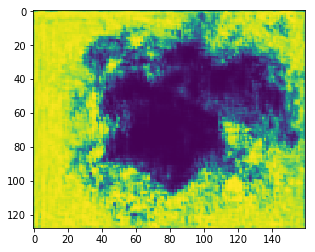

(62, 128, 160, 3)


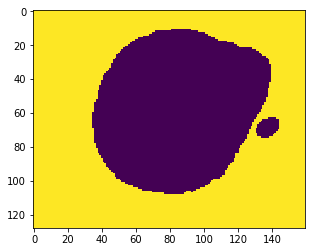

In [0]:
# risultato della predizione, slice 0 con label = 0
image = (predicted_image[0][:, :,0] * 255.).astype(np.uint8)
img = Image.fromarray(image)  
img = PIL.ImageOps.invert(img)
plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 0 (prima ne facciamo il one-hot-encoding)
test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image = (d[0][:, :,0] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt_maschera.imshow(img)
plt_maschera.show()

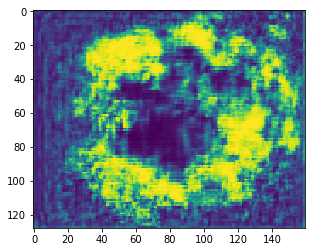

(62, 128, 160, 3)


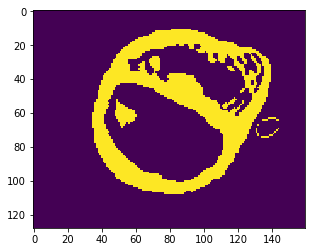

In [0]:
# risultato della predizione, slice 0 con label = 1
image = (predicted_image[0][:, :,1] * 255.).astype(np.uint8)
img = Image.fromarray(image)
img = PIL.ImageOps.invert(img)
plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 1 (prima ne facciamo il one-hot-encoding)
test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image = (d[0][:, :,1] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt_maschera.imshow(img)
plt_maschera.show()

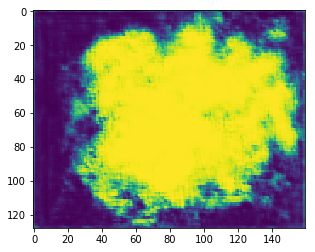

(62, 128, 160, 3)


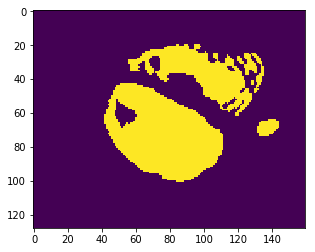

In [0]:
# risultato della predizione, slice 0 con label = 2
image = (predicted_image[0][:, :,2] * 255.).astype(np.uint8)
img = Image.fromarray(image) 
img = PIL.ImageOps.invert(img)
plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 2 (prima ne facciamo il one-hot-encoding)
test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image = (d[0][:, :,2] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt_maschera.imshow(img)
plt_maschera.show()